

--------------------------------------------------------------------------------------------MÔ TẢ BÀI TOÁN--------------------------------------------------------------------------------------------



> Bài toán phát hiện tính châm biếm trong các bình luận, câu văn, tiêu đề,.. trên các trang mạng xã hội như (Twiter, Facebook, Instagram,..) hay trong các trang báo. Việc thu thập dữ liệu cho bài toán này rất khó. Các bình luận, tiêu đề đến từ nhiều ngôn ngữ, nhiều lĩnh vực, có thể chứa nhiều thông tin không cần thiết, có thể có lỗi chính tả. Việc dán nhãn cũng phải được thực hiện khó khăn, không có tiêu chuẩn cụ thể cho người dán nhãn để phát hiện châm biếm.



> Bộ dữ liệu đã có là những tiêu đề được lấy từ 2 trang báo Onion và HuffPost. Onion là trang báo chỉ đăng những tin châm biếm. HuffPost là trang báo uy tín, đăng những tin chính thống. Đây là bộ dữ liệu sạch, rõ ràng đáp ứng những yêu cầu sau:
*   Dữ liệu hoàn toàn bằng tiếng Anh.
*   Các tiêu đề được viết bởi những người chuyên nghiệp, không có lỗi chính tả.
*   Hai trang báo có uy tín cao trong những bài viết của mình, có sự rõ ràng giữa những tiêu đề có châm biếm và những tiêu đề không châm biếm.








In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Import data


In [368]:
df = pd.read_json("./Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.drop(["article_link"], axis=1)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [6]:
num_sarcastic = df.sum(axis=0, skipna=True)['is_sarcastic']
num_nonsarcastic = len(df) - num_sarcastic

Text(1, 14985, '14985')

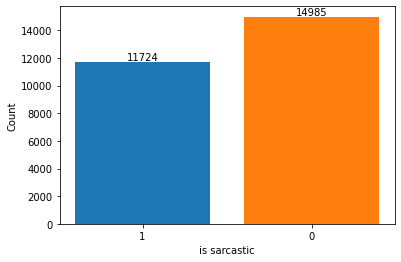

In [7]:
labels = [1, 0]
x = np.arange(len(labels))
fig, ax = plt.subplots()
rect_1 = ax.bar(x[0], num_sarcastic)
rect_2 = ax.bar(x[1], num_nonsarcastic)
ax.set_ylabel('Count')
ax.set_xlabel('is sarcastic')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.annotate(
    '{}'.format(num_sarcastic),
    xy=(x[0], num_sarcastic),
    ha='center', va='bottom',
    )
ax.annotate(
    '{}'.format(num_nonsarcastic),
    xy=(x[1], num_nonsarcastic),
    ha='center', va='bottom',
    )

Ta thấy số lượng tiêu đề châm biếm và không châm biếm cân bằng nhau trong bộ dữ liệu

# Pre-training data, using  NLTK library

***USING NLTK LIBRARY***

In [8]:
!pip install -U nltk

     |████████████████████████████████| 1.4MB 4.7MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434672 sha256=aee87e3dc81a139db9e79dc766d2ad5f8cf5aaccc6a5e2394547f67db6b4c2d1
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [9]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

**Tiền xử lí dữ liệu:**


*   Chuyển các chữ in hoa thành in thường.
*   Xóa các kí tự đặc biệt như: ' [ / ( ) { } \ [ \ ] \ | @ , ; ] ' 
*   Xóa các từ stopwords.



In [10]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    
    return text

In [11]:
df['headline'] = df['headline'].apply(clean_text)
df.head()['headline']

0    former versace store clerk sues secret black c...
1    roseanne revival catches thorny political mood...
2    mom starting fear sons web series closest thin...
3    boehner wants wife listen come alternative deb...
4    jk rowling wishes snape happy birthday magical...
Name: headline, dtype: object

***Stem*** (đưa các từ về dạng nguyên mẫu trong tiếng Anh) các từ trong bộ dữ liệu.

Lưu dữ liệu đã được áp dụng *stem* để so sánh với dữ liệu không *stem*.

In [12]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def convert_to_sentence(tokens):
  s = ''
  for token in tokens:
    s += token + ' '
  s = s.strip()
  return s

def stemming(text):
  tokens = text.split()
  tokens = [porter.stem(w) for w in tokens] 
  new_sentence = convert_to_sentence(tokens)

  return new_sentence

In [13]:
stemmed_df = df['headline'].apply(stemming)
stemmed_df.head()

0    former versac store clerk sue secret black cod...
1    roseann reviv catch thorni polit mood better wors
2    mom start fear son web seri closest thing gran...
3    boehner want wife listen come altern debtreduc...
4          jk rowl wish snape happi birthday magic way
Name: headline, dtype: object

# Split train, test


Chia bộ dữ liệu thành 2 bộ train và test theo tỉ lệ 8/2

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['is_sarcastic'], train_size=0.8, random_state=0)

In [15]:
Xstem_train, Xstem_test, ystem_train, ystem_test = train_test_split(stemmed_df, df['is_sarcastic'], train_size=0.8, random_state=0)

# Feature engineering

Sử dụng Word Frequencies với TfidfVectorizer.

TfidfVectorizer sẽ tách từ, xây dựng bộ từ vựng từ dữ liệu của bộ train.

Bộ từ vựng là một vector, mỗi từ được gán 1 vị trí số nguyên duy nhất.

Vector tần suất được tính tương ứng cho các từ trong bộ từ vựng, từ có tần suất cao nhất được gán giá trị thấp nhất là 1,0.

Đối với dữ liệu test, nếu có các từ không xuất hiện trong bộ từ vựng thì các từ này sẽ được bỏ qua.

Dữ liệu không stem

In [118]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

vector_train = vectorizer.transform(X_train)
vector_test = vectorizer.transform(X_test)

print(vector_train.shape)
print(vector_test.shape)

{'area': 1624, 'ostrich': 16002, 'lashes': 12841, 'unnecessarily': 23668, 'restrictive': 18904, 'zoning': 25179, 'laws': 12907, 'frugal': 9229, 'star': 21391, 'wars': 24379, 'fan': 8337, 'camping': 3684, 'front': 9213, '99cent': 606, 'theater': 22535, 'decorative': 6093, 'throw': 22658, 'pillow': 16857, 'positively': 17242, 'aching': 738, 'quick': 18029, 'plump': 17039, 'damaging': 5876, 'stigmas': 21537, 'men': 14190, 'color': 4784, 'makeup': 13684, 'face': 8238, 'dr': 7053, 'scholls': 19761, 'introduces': 11838, 'new': 15258, 'cartilage': 3877, 'inserts': 11668, 'allday': 1129, 'knee': 12588, 'pain': 16233, 'relief': 18638, 'doublejointed': 7004, 'man': 13714, 'date': 5951, 'breaks': 3207, 'early': 7312, 'boilermakers': 2959, 'protest': 17766, 'purdues': 17926, 'mascot': 13904, 'touring': 22922, 'company': 4896, 'cats': 3955, 'prepares': 17457, 'yet': 25067, 'another': 1391, 'day': 5970, 'goddamn': 9727, 'catsuits': 3956, 'jeb': 12093, 'bush': 3521, 'would': 24925, 'course': 5437, 's

Ta thấy bộ từ vựng có 25194 từ.

In [17]:
print(vector_train[0])

  (0, 25179)	0.4002035964591255
  (0, 23668)	0.42914961621321124
  (0, 18904)	0.41221728011193726
  (0, 16002)	0.42914961621321124
  (0, 12907)	0.33299301995694935
  (0, 12841)	0.38327126035785153
  (0, 1624)	0.2092701574760716


Dữ liệu đã stem từ

In [117]:
vectorizer_stem = TfidfVectorizer()
vectorizer_stem.fit(Xstem_train)
print(vectorizer_stem.vocabulary_)
print(vectorizer_stem.idf_)

vectorStem_train = vectorizer_stem.transform(Xstem_train)
vectorStem_test = vectorizer_stem.transform(Xstem_test)

print(vectorStem_train.shape)
print(vectorStem_test.shape)

{'area': 1280, 'ostrich': 11318, 'lash': 9001, 'unnecessarili': 16542, 'restrict': 13202, 'zone': 17669, 'law': 9040, 'frugal': 6382, 'star': 14952, 'war': 17045, 'fan': 5744, 'camp': 2739, 'front': 6369, '99cent': 589, 'theater': 15715, 'decor': 4314, 'throw': 15804, 'pillow': 11927, 'posit': 12189, 'ach': 667, 'quick': 12688, 'plump': 12051, 'damag': 4165, 'stigma': 15046, 'men': 9969, 'color': 3501, 'makeup': 9605, 'face': 5680, 'dr': 4913, 'scholl': 13802, 'introduc': 8229, 'new': 10760, 'cartilag': 2869, 'insert': 8141, 'allday': 925, 'knee': 8792, 'pain': 11497, 'relief': 13071, 'doublejoint': 4880, 'man': 9630, 'date': 4220, 'break': 2385, 'earli': 5098, 'boilermak': 2229, 'protest': 12515, 'purdu': 12616, 'mascot': 9756, 'tour': 15988, 'compani': 3557, 'cat': 2899, 'prepar': 12335, 'yet': 17569, 'anoth': 1112, 'day': 4233, 'goddamn': 6758, 'catsuit': 2921, 'jeb': 8408, 'bush': 2630, 'would': 17463, 'cours': 3860, 'support': 15335, 'donald': 4837, 'trump': 16173, 'nomin': 10879,

Bộ từ vựng có 17681 từ. Vì sau quá trình stem đã có nhiều từ trùng nhau.

In [19]:
print(vectorStem_train[0])

  (0, 17669)	0.36264109592649063
  (0, 16542)	0.4643718725905546
  (0, 13202)	0.37978937229647863
  (0, 11318)	0.4643718725905546
  (0, 9040)	0.2841187195302858
  (0, 9001)	0.40172837070020306
  (0, 1280)	0.22552131942766498


# Apply models.

In [20]:
def show_score(train, test):
  bnb = BernoulliNB()
  lgr = LogisticRegression()
  svm = SVC()
  mlp = MLPClassifier()

  name = ['BernoulliNB', 'SVM', 'LogisticRegression', 'MLPClassifier']

  for model, name in zip([bnb, svm, lgr, mlp], name):
    model.fit(train, y_train)

    print(f"{name}:")
    print("Accuracy on training set: {:.3f}".format(model.score(train, y_train)))
    print("Accuracy on test set: {:.3f}".format(model.score(test, y_test)))

In [21]:
show_score(vector_train, vector_test)

BernoulliNB:
Accuracy on training set: 0.922
Accuracy on test set: 0.804
SVM:
Accuracy on training set: 0.990
Accuracy on test set: 0.806
LogisticRegression:
Accuracy on training set: 0.901
Accuracy on test set: 0.795
MLPClassifier:
Accuracy on training set: 1.000
Accuracy on test set: 0.772


In [22]:
show_score(vectorStem_train, vectorStem_test)

BernoulliNB:
Accuracy on training set: 0.895
Accuracy on test set: 0.803
SVM:
Accuracy on training set: 0.982
Accuracy on test set: 0.801
LogisticRegression:
Accuracy on training set: 0.878
Accuracy on test set: 0.788
MLPClassifier:
Accuracy on training set: 1.000
Accuracy on test set: 0.739


Ta thấy bộ dữ liệu có stem từ cho kết quả thấp hơn bộ dữ liệu không áp dụng stem từ => Chọn bộ dữ liệu không *stem* từ.

Chọn **SVM** model vì nó có kết quả cao nhất.

Tiến hành tuning hyper parameter.

Sử dụng GridSearchCV.

In [53]:
# Tạo các tham số cần thử
param_grid = {'C': [0.1,1,10], 'gamma': [10,1,0.1],'kernel': ['rbf', 'poly', 'sigmoid']}

In [54]:
grid = GridSearchCV(SVC(),param_grid,verbose=2)
grid.fit(vector_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=0.1, gamma=10, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=0.1, gamma=10, kernel=rbf, total= 1.3min
[CV] C=0.1, gamma=10, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ...................... C=0.1, gamma=10, kernel=rbf, total= 1.3min
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total= 1.2min
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total= 1.2min
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total= 1.3min
[CV] C=0.1, gamma=10, kernel=poly ....................................
[CV] ..................... C=0.1, gamma=10, kernel=poly, total= 1.4min
[CV] C=0.1, gamma=10, kernel=poly ....................................
[CV] ..................... C=0.1, gamma=10, kernel=poly, total= 1.4min
[CV] C=0.1, gamma=10, kernel=poly ....................................
[CV] ..................... C=0.1, gamma=10, kernel=poly, total= 1.4min
[CV] C=0.1, gamma=10, kernel=poly ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 139.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [10, 1, 0.1],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [61]:
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Best: 0.798661 using {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [56]:
grid_predictions = grid.predict(vector_test)

In [62]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[2582  425]
 [ 600 1735]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3007
           1       0.80      0.74      0.77      2335

    accuracy                           0.81      5342
   macro avg       0.81      0.80      0.80      5342
weighted avg       0.81      0.81      0.81      5342



Tạo model với các tham số tốt nhất

In [23]:
best_model = SVC(C=10, gamma=1, kernel='rbf')

In [24]:
best_model.fit(vector_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [365]:
best_model.score(vector_test, y_test)

0.8081242980157245

# Áp dụng model trên 2000 headlines mới





Cách lấy dữ liệu thực hiện [tại đây](https://drive.google.com/drive/folders/1GKPxe7OWpz-eFiUz5DFl04zjEFZ5MzUJ?usp=sharing)



Tạo bộ dự liệu từ 2 file dữ liệu được lấy về.

Bộ dữ liệu này bao gồm 1100 headlines của trang [Huffpost](https://www.huffpost.com/) với nhãn 0 và 900 headlines của trang [The onion](https://www.theonion.com/) với nhãn 1.

In [120]:
df_huffpost = pd.read_csv('./huffpost.csv')
df_huffpost.head()

,web-scraper-order,web-scraper-start-url,headlines
0,1592909279-4416,https://www.huffpost.com/news/,Joe Biden Mocked In Trump Campaign Ad For Knee...
1,1592909279-4804,https://www.huffpost.com/news/,Tammy Duckworth: Trump's Use Of Military Again...
2,1592909279-3877,https://www.huffpost.com/news/,Donald Trump Vows To Keep Trying To End Dreame...
3,1592909279-4019,https://www.huffpost.com/news/,Rep. Ilhan Omar’s Father Dies From Complicatio...
4,1592909279-4667,https://www.huffpost.com/news/,Protesters Topple Confederate Statue In Virgin...


In [121]:
df_huffpost = df_huffpost.drop(["web-scraper-order", "web-scraper-start-url"], axis=1)

Dán nhãn 0 cho các headlines của huffpost

In [172]:
df_huffpost['is_sarcastic'] = 0

In [173]:
df_huffpost.head()

,headlines,is_sarcastic
0,Joe Biden Mocked In Trump Campaign Ad For Knee...,0
1,Tammy Duckworth: Trump's Use Of Military Again...,0
2,Donald Trump Vows To Keep Trying To End Dreame...,0
3,Rep. Ilhan Omar’s Father Dies From Complicatio...,0
4,Protesters Topple Confederate Statue In Virgin...,0


In [174]:
df_theonion = pd.read_csv('./union.csv')
df_theonion.head()

,web-scraper-order,web-scraper-start-url,headlines
0,1592922726-6574,https://www.theonion.com/latest?startTime=1589...,Updated Patriot Act Finally Legalizes 80% Of C...
1,1592922906-6811,https://www.theonion.com/latest?startTime=1592...,Tips For Going To Protests
2,1592922302-6003,https://www.theonion.com/latest?startTime=1584...,Biden Pledges To Select Woman As Vice Presiden...
3,1592922922-6825,https://www.theonion.com/latest?startTime=1592...,Fantasy Baseball League Commissioner Knows Han...
4,1592922743-6585,https://www.theonion.com/latest?startTime=1589...,Recipe Calls For Banana As If Man Has Access T...


In [175]:
df_theonion = df_theonion.drop(['web-scraper-order', 'web-scraper-start-url'], axis=1)

Dán nhãn 1 cho các headlines từ theonion

In [176]:
df_theonion['is_sarcastic'] = np.int64(1)

In [177]:
df_theonion.head()

,headlines,is_sarcastic
0,Updated Patriot Act Finally Legalizes 80% Of C...,1
1,Tips For Going To Protests,1
2,Biden Pledges To Select Woman As Vice Presiden...,1
3,Fantasy Baseball League Commissioner Knows Han...,1
4,Recipe Calls For Banana As If Man Has Access T...,1


Tạo một DataFrame mới

In [178]:
new_df_1 = pd.DataFrame(df_huffpost.values[0:1100], columns=['headlines', 'is_sarcastic'])
new_df_2 = pd.DataFrame(df_theonion.values[0:900], columns=['headlines', 'is_sarcastic'])
new_df = new_df_1.append(new_df_2, ignore_index=True)

In [179]:
# Xóa các hàng có dữ liệu rỗng (NaN)
new_df = new_df.dropna()
new_df

,headlines,is_sarcastic
0,Joe Biden Mocked In Trump Campaign Ad For Knee...,0
1,Tammy Duckworth: Trump's Use Of Military Again...,0
2,Donald Trump Vows To Keep Trying To End Dreame...,0
3,Rep. Ilhan Omar’s Father Dies From Complicatio...,0
4,Protesters Topple Confederate Statue In Virgin...,0
...,...,...
1995,Oscar Meyer Whiner,1
1996,Man Hates How Hot Dog-Eating Contests Reduce A...,1
1997,Report: Amazon Using Heat-Sensing Alien Hunter...,1
1998,Germany Cancels Oktoberfest Due To Coronavirus...,1


In [231]:
new_df['is_sarcastic'] = new_df['is_sarcastic'].astype('int64')

Tiền xử lý trên bộ dữ liệu mới

In [232]:
new_df['headlines'] = new_df['headlines'].apply(clean_text)
new_df.head()['headlines']

0    joe biden mocked trump campaign ad kneeling ch...
1    tammy duckworth trumps use military protesters...
2    donald trump vows keep trying end dreamer prot...
3    rep ilhan omars father dies complications covid19
4    protesters topple confederate statue virginia ...
Name: headlines, dtype: object

Chuyển dữ liệu chữ thành vector số

In [233]:
X_new = new_df['headlines']
y_new = new_df['is_sarcastic']

In [234]:
vector_new = vectorizer.transform(X_new)
print(vector_new.shape)

(2000, 25194)


Dùng model đã tạo để dự đoán trên bộ dữ liệu mới

In [236]:
best_model.score(vector_new, y_new)

0.6985

In [238]:
print(confusion_matrix(y_new, best_model.predict(vector_new)))
print(classification_report(y_new, best_model.predict(vector_new)))

[[946 154]
 [449 451]]
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1100
           1       0.75      0.50      0.60       900

    accuracy                           0.70      2000
   macro avg       0.71      0.68      0.68      2000
weighted avg       0.71      0.70      0.69      2000



# Chương trình dự đoán một headline bất kì

In [259]:
input = "Realtor Thinks Flourishing Neighborhood Full Of Middle-Class Latino Families Has Real Turnaround Potential"

In [260]:
# Tiền xử lí
clean_input = [clean_text(input)]
# Chuyển thành vector
vec_input = vectorizer.transform(clean_input)
# Dự đoán
if best_model.predict(vec_input) == 0:
  print("Headline is not sarcastic")
else:
  print("Headline is sarcastic")

Headline is sarcastic


# Nhận xét

Ta thấy hiệu suất trên 2000 headlines mới thấp hơn so với hiệu suất trên dữ liệu cũ (70% so với 80%).

Để bài toán này càng đạt được kết quả cao thì cần có thêm nhiều input, nhằm tăng số lượng từ trong bộ từ vựng. Số từ vựng tiếng Anh hiện nay khoảng 171.476 từ (theo Wikipedia) tuy nhiên model chỉ được xây dựng trên 25.194 từ nên hiệu suất sẽ không cao.